# Crafting a first data set. 
Things that need to be done: 
- find a set of satellite images that is tagged with locations
- find a granular poverty data set taht includes locations taht can be mapped to the images
- join the datasets 

## Packages

In [2]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
import time

from collections import defaultdict
from glob import glob
import random as rd
import pylab as pl
import pandas as pd
import re
from sklearn import decomposition
from sklearn import pipeline


from PIL import Image
import PIL.ImageOps

from skimage import io, color
import matplotlib.image as mpimg
from skimage.transform import resize

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import classification_report, mean_squared_error

import seaborn as sns
from sklearn.metrics import confusion_matrix

import ntpath
import geopandas as gpd
import geoplot
from shapely.geometry import Point, Polygon
from fiona.crs import from_epsg
import pygeos
import math


/Users/johannes/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Import and transform images

In [3]:
# set the random seed for reproducibility
rd.seed(3)

In [4]:
#data_size = int(input("Please input an integer (maybe like 300)"))


In [5]:
#get all the pathlinks to the images
raw_images_links = glob("image_data/malawi_archive/images/*")

In [6]:
#transform the images into arrays
malawi_arrays = [np.array(Image.open(file_name)) for file_name in raw_images_links]
malawi_arrays[0].shape

(256, 256, 4)

In [7]:
#test for identity:
def is_arr_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if elem is myarr), False)

In [8]:
## New try
malawi_unique = []
unique_indices = []
for id, file_name in enumerate(raw_images_links):
    im_array = np.array(Image.open(file_name))

    if id == 0:
        malawi_unique.append(im_array)
        unique_indices.append(id)

    if is_arr_in_list(im_array, malawi_unique) == False:
        malawi_unique.append(im_array)
        unique_indices.append(id)

In [10]:
#flatten the data and resize if necessary

#resize the data and flatten it
def transform(dataset):
    new_list = []
    for i in range(len(dataset)):
        #resize the image
        temp2 = resize(dataset[i], (256, 256), Image.NEAREST)
        
        #flatten it
        new_list.append(temp2.flatten())

    return new_list

#do this for malawi
malawi_transform = transform(malawi_arrays)

In [214]:
malawi_transform[0].shape

(262144,)

In [12]:
n_samples = 50
n_comps_filter =20
pca_filter = PCA(n_comps_filter)
pca_filter.fit(rd.sample(malawi_transform, n_samples))
print(f"Completed training the PCA for filtering with {n_samples} samples and {n_comps_filter} components. \nvar expl: {round(np.cumsum(pca_filter.explained_variance_ratio_)[n_comps_filter-1]*100)}%")
malawi_pca_filter = pca_filter.transform(malawi_transform)

Completed training the PCA for filtering with 50 with var expl: 91%


In [13]:
malawi_unique, unique_indices = np.unique(malawi_pca_filter, axis= 0, return_index= True)

In [14]:
malawi_filtered = pca_filter.inverse_transform(malawi_unique)

In [15]:
#scale the data using StandardScaler
#StandarScaler normalies the images by subtracting the mean and dividing by the unit variance. 
def return_scaled(input_array):
    scaler = StandardScaler(copy=False)
    scaler.fit(rd.sample(input_array,1000))
    data_set = scaler.fit_transform(input_array)

    return data_set

In [16]:
"""stages = []
assemblerInputs = malawi_transform
assemblerInputs = [column for column in assemblerInputs if column not in columns_to_remove_from_assembler]
#add vector assembler
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features_nonscaled")
stages += [assembler]

col_scaler = StandardScaler(inputCol='features_nonscaled', outputCol='features',withStd=True, withMean=False)
stages += [col_scaler]

pipeline = Pipeline(stages = stages)
assemblerModel = pipeline.fit(df)"""

'stages = []\nassemblerInputs = malawi_transform\nassemblerInputs = [column for column in assemblerInputs if column not in columns_to_remove_from_assembler]\n#add vector assembler\nassembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features_nonscaled")\nstages += [assembler]\n\ncol_scaler = StandardScaler(inputCol=\'features_nonscaled\', outputCol=\'features\',withStd=True, withMean=False)\nstages += [col_scaler]\n\npipeline = Pipeline(stages = stages)\nassemblerModel = pipeline.fit(df)'

## Merging the image data with the outcome data

In [17]:
#load outcome data
outcome_geodf = gpd.read_file("outcome_data/ml_gdf.shp")

In [18]:
#have a look 
outcome_geodf.head()

,DHSID,DHSCLUST,LATNUM,LONGNUM,hv271,geometry
0,MW201500000001,1.0,-13.360652,33.923942,221426,POINT (33.92394 -13.36065)
1,MW201500000001,1.0,-13.360652,33.923942,182618,POINT (33.92394 -13.36065)
2,MW201500000001,1.0,-13.360652,33.923942,83533,POINT (33.92394 -13.36065)
3,MW201500000001,1.0,-13.360652,33.923942,103794,POINT (33.92394 -13.36065)
4,MW201500000001,1.0,-13.360652,33.923942,40480,POINT (33.92394 -13.36065)


In [19]:
# Get the location of the images 
image_geodf = gpd.GeoDataFrame() # Create an empty geopandas GeoDataFrame
for i in unique_indices:
    #extract an array of the geo points from the file name 
    point_array = [float(point) for point in str.split(ntpath.basename(raw_images_links[i][:-4]),"_")]

    lat_i = 1
    long_i = 0
    #calculate the width of the image taken
    #https://wiki.openstreetmap.org/wiki/Zoom_levels 
    meters = 40075016.686 * math.cos(math.radians(point_array[lat_i]))/(2**14)

    #the tiles are x-meters wide. Let's find that in degrees: 
    # (https://stackoverflow.com/questions/25237356/convert-meters-to-decimal-degrees)
    width_deg_half = (meters / (111.32 * 1000 * math.cos(point_array[lat_i] * (math.pi / 180))))/2

    geo_point = [(point_array[lat_i] - width_deg_half, point_array[long_i]+ width_deg_half),
                (point_array[lat_i] + width_deg_half, point_array[long_i]+ width_deg_half),
                (point_array[lat_i] + width_deg_half, point_array[long_i] - width_deg_half),
                (point_array[lat_i] - width_deg_half, point_array[long_i] - width_deg_half)]

    # Create a Shapely polygon from the coordinate-tuple list
    image_geodf.loc[i, 'geometry'] = Polygon(geo_point)
    # assign an image id. used for merging with actual images and the survey values
    image_geodf.loc[i, 'image_id'] = i  

    # Set the GeoDataFrame's coordinate system to WGS84 (i.e. epsg code 4326)
image_geodf.crs = from_epsg(4326)

/Users/johannes/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [20]:
#merge based on whether an image contains the point 
geo_df = image_geodf.sjoin(outcome_geodf, how="inner", predicate = "contains")

In [21]:
#look at the merged geodata frame
geo_df.head()

,geometry,image_id,index_right,DHSID,DHSCLUST,LATNUM,LONGNUM,hv271
11717,"POLYGON ((35.65555 -14.77108, 35.67753 -14.771...",11717.0,13078,MW201500000422,422.0,-14.787518,35.65937,-79952
8201,"POLYGON ((35.64058 -14.77108, 35.66255 -14.771...",8201.0,13078,MW201500000422,422.0,-14.787518,35.65937,-79952
11717,"POLYGON ((35.65555 -14.77108, 35.67753 -14.771...",11717.0,13062,MW201500000422,422.0,-14.787518,35.65937,-72030
8201,"POLYGON ((35.64058 -14.77108, 35.66255 -14.771...",8201.0,13062,MW201500000422,422.0,-14.787518,35.65937,-72030
11717,"POLYGON ((35.65555 -14.77108, 35.67753 -14.771...",11717.0,13061,MW201500000422,422.0,-14.787518,35.65937,-30373


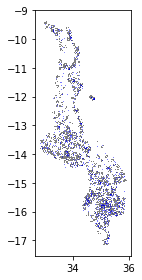

In [22]:
# Create plot
ax = image_geodf.plot(facecolor='grey')
outcome_geodf.plot(ax=ax, color='blue', markersize = .001, alpha = 0.2)
plt.tight_layout()

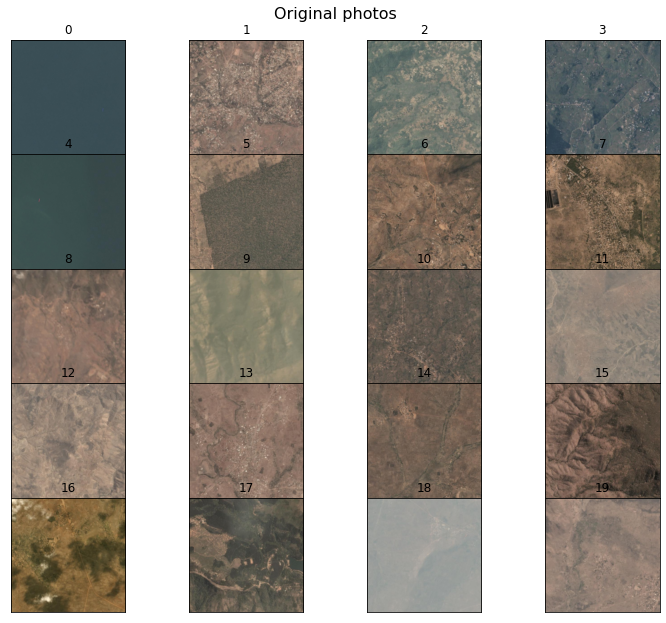

In [23]:
### peak into the data

n_col = 5
n_row = 4
## show the original images
plt.figure(figsize=(2. * n_col, 2.26 * n_row))
plt.suptitle('Original photos', size=16)

#loop through some random images
for i, comp in enumerate(malawi_transform[:n_col*n_row]):
    plt.subplot(n_col, n_row, i + 1)
    #comp = scaler.inverse_transform(comp)
    comp = (comp * 255).astype(np.uint8)
    plt.imshow(comp.reshape(256,256,4))
    plt.title(i)
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

/Users/johannes/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:123: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return PathPatch(path, **kwargs)


<AxesSubplot:>

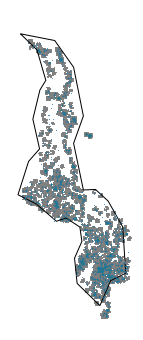

In [24]:
#Create plot wiht Malawi outline
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres'))
ax = geoplot.polyplot(image_geodf, color = 'grey')
geoplot.polyplot(world.query('name == "Malawi"'), ax = ax)
outcome_geodf.plot(markersize = 0.01, alpha = 0.2, ax = ax)

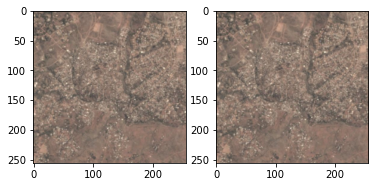

In [26]:
## Select a single image by it's ID to be printed
comp = malawi_transform[1]
#comp = scaler.inverse_transform(comp)
plt.figure()
plt.subplot(1, 2, 1)
comp = (comp * 255).astype(np.uint8)
plt.imshow(comp.reshape(256,256,4))

comp = malawi_transform[1784]
plt.subplot(1, 2, 2)
comp = (comp * 255).astype(np.uint8)
plt.imshow(comp.reshape(256,256,4))

In [27]:
# remove duplicate images. 

print(raw_images_links[1])
print(raw_images_links[1784])


np.mean(np.asarray(Image.open(raw_images_links[1])) == np.asarray(Image.open(raw_images_links[1784])))

image_data/malawi_archive/images/-15.84688_35.071951921402_-15.84688_35.05698.png
image_data/malawi_archive/images/-15.843423764205975_35.080483842803986_-15.798507999999998_35.050540000000005.png


1.0

## Assemble Data Set

In [28]:
#make empty lists
X_full = []
Y_full = []
#fill them with the image data and the outcome data
for i in range(len(geo_df)):
    obs = geo_df.iloc[i]
    X_full.append(malawi_transform[int(obs['image_id'])])
    Y_full.append(obs['hv271'])

In [29]:
#split into train and test data set
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_full, test_size=0.15)

In [258]:
len(np.unique(y_train))

10568

## PCA

Haven't tried and will probably take forever to run but there is the code 

In [30]:
# Let's find how many components we should use by just applying a PCA with a range of components

#initialize the pca
pca = PCA(whiten=True, copy=True, random_state= 10)
#fit it
pca.fit(rd.sample(X_train,100))

#get the cumulative 
total = np.cumsum(pca.explained_variance_ratio_)

In [31]:
total[26]

0.8785872742319315

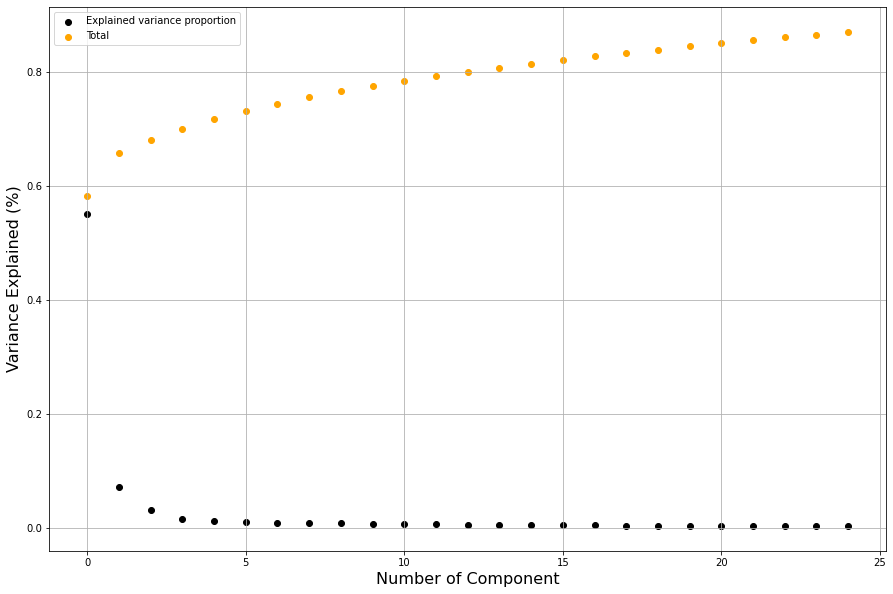

[0.55117302 0.07207358 0.03162077 0.01514397 0.01228577 0.01098309
 0.00938464 0.0089208  0.00829677 0.00725502 0.00705346 0.00648874
 0.00579461 0.00509328 0.00469478 0.00455991 0.00444319 0.00412243
 0.0040304  0.00379809 0.00357578 0.00345635 0.00337475 0.00321973
 0.00308975]


In [257]:
plt.figure(figsize=(15, 10))
comp_to_view = 25
#let's plot it
plot_xs = list(range(comp_to_view))


plt.scatter(plot_xs, pca.explained_variance_ratio_[:comp_to_view], color='black', label='Explained variance proportion')
plt.scatter(plot_xs, total[:comp_to_view],color='orange', label='Total')

plt.legend(loc=2)
plt.xlabel('Number of Component', size=16)
plt.ylabel('Variance Explained (%)', size=16)
#plt.hlines(0.,xmin=0, xmax=comp_to_view, colors = 'blue', linestyles='--')
plt.grid('minor')
plt.show()

print(pca.explained_variance_ratio_[:comp_to_view])

In [170]:
#initialize the pca

n_comp = 25
pca = PCA(n_components = n_comp, whiten=True, copy=True, random_state= 10)

#fit with random sample of _ observations
pca.fit(rd.sample(X_train,1000))


PCA(n_components=25, random_state=10, whiten=True)

In [171]:
pca.components_.shape

(25, 262144)

In [172]:
## batchwise transformation of the 

reduced = []
batchsize = 2500
# 
for i in range(0, len(X_train), batchsize):
    if i == 0:
        reduced = pca.transform(X_train[i:i+batchsize])
        continue 
    
    reduced_batch = pca.transform(X_train[i:i+batchsize])
    reduced = np.concatenate((reduced, reduced_batch), axis =0)


In [35]:
# Ideas from Will
# Kernel Trick 
# Random Projection
# IRLS (iterarated reweighted)

In [173]:
X_train_pca = np.asarray(reduced)
len(X_train_pca)

13337

In [255]:
pd.DataFrame(X_train_pca, y_train).to_csv("train_set_pca.csv")

In [265]:
len(np.unique(X_train_pca[:,1]))
len(np.unique(y_train))

10568

In [175]:
import matplotlib.image as mpimg
#function straight copied from
def plot_gallery(title, images, n_col=n_col, n_row=n_row, cmap_p=plt.cm.gray):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        #print(vmax)
        plt.imshow((comp*255).astype(np.uint8),
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax 
                   #cmap = cmap_p
                   )
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

In [139]:
"""eigenimages = pca.components_.reshape(25,256,256,4).copy()
#eigenimages[:,:,:,-1] += .5
eigenimages[:,:,:,0] += np.mean(eigenimages[:,:,:,0])
eigenimages[:,:,:,1] += np.mean(eigenimages[:,:,:,1])
eigenimages[:,:,:,2] += np.mean(eigenimages[:,:,:,2])"""


In [176]:
np.mean(eigenimages[:,:,:,2])

-0.00044206058898738835

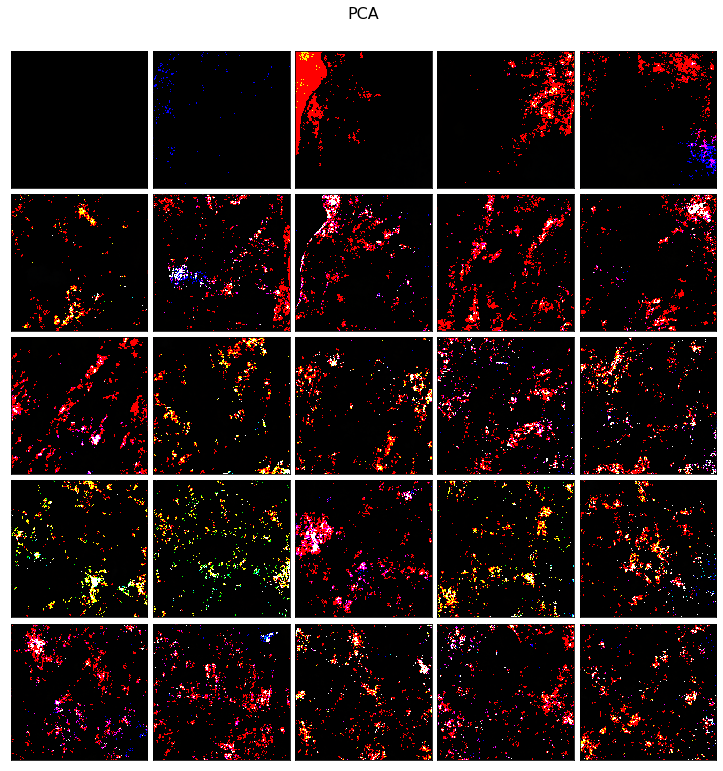

In [212]:
plot_gallery("PCA", eigenimages[:,:,:,:3], n_col=5, n_row=5, cmap_p = plt.cm.viridis)

# Models

In [233]:
# linear regression with full un-PCAed data blows up the kernel
# DO NOT RUN WITH EXTRA DATA
lin_model = LinearRegression()
lin_model.fit(X_train_pca, y_train)

LinearRegression()

In [234]:
lin_model.score(X_train_pca, y_train)

0.05643447919237554

In [184]:
len(np.unique(X_train_pca))

11275

(array([2877., 4309., 2047., 1219.,  884.,  690.,  585.,  379.,  278.,
          69.]),
 array([-122719. ,  -70784.6,  -18850.2,   33084.2,   85018.6,  136953. ,
         188887.4,  240821.8,  292756.2,  344690.6,  396625. ]),
 <BarContainer object of 10 artists>)

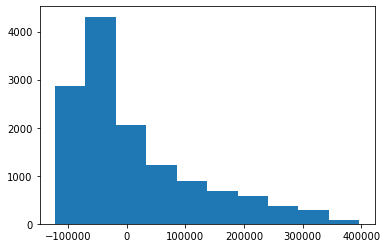

In [185]:
plt.hist((y_train))

In [186]:
from sklearn.ensemble import RandomForestRegressor

In [187]:
rf = RandomForestRegressor(n_estimators= 100, bootstrap = True)
rf.fit(X_train_pca, y_train)

RandomForestRegressor()

In [188]:
rf.score(X_train_pca, y_train)

0.5362286712346925

## Running Grid Search on Random Forest Regressor

Source and documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

Tuning: 
- n_estimators: number of trees in the forest
- max_depth: maximum depth of the tree 
- max_features: number of features taken into account when splitting. 

In [217]:
hyper_n_list = [100]
hyper_depth_list = [1,2,3,4,5, 10,16,18,20,22,24,26, 30, 40, 50, 100, 200]
hyper_m_list = ["auto", "sqrt", "log2"]

In [218]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=0),
                           {
                              'n_estimators':[100],
                              'max_depth': hyper_depth_list,
                              'max_features': hyper_m_list,
                            },cv=4, scoring="r2",verbose=1,n_jobs=-1
                           )
grid_search.fit(X_train_pca,y_train)

Fitting 4 folds for each of 51 candidates, totalling 204 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 204 out of 204 | elapsed:  2.4min finished


GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4, 5, 10, 16, 18, 20, 22, 24,
                                       26, 30, 40, 50, 100, 200],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100]},
             scoring='r2', verbose=1)

In [219]:
cv_df = pd.DataFrame(grid_search.cv_results_)

In [242]:
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,1.356039,0.018550,0.021361,0.000823,1,auto,100,"{'max_depth': 1, 'max_features': 'auto', 'n_es...",0.047921,0.041250,0.040792,0.045897,0.043965,0.003034,49
1,0.555069,0.010110,0.023091,0.003796,1,sqrt,100,"{'max_depth': 1, 'max_features': 'sqrt', 'n_es...",0.044742,0.039533,0.040643,0.042764,0.041920,0.002000,50
2,0.514446,0.009677,0.025483,0.008459,1,log2,100,"{'max_depth': 1, 'max_features': 'log2', 'n_es...",0.043884,0.038757,0.039189,0.041256,0.040772,0.002030,51
3,2.156072,0.018617,0.025452,0.006821,2,auto,100,"{'max_depth': 2, 'max_features': 'auto', 'n_es...",0.107651,0.109106,0.109202,0.110703,0.109165,0.001080,46
4,0.658431,0.014898,0.029117,0.006025,2,sqrt,100,"{'max_depth': 2, 'max_features': 'sqrt', 'n_es...",0.093756,0.083887,0.088553,0.091186,0.089345,0.003649,47
5,0.613706,0.030883,0.021652,0.004034,2,log2,100,"{'max_depth': 2, 'max_features': 'log2', 'n_es...",0.091664,0.083035,0.084878,0.085836,0.086353,0.003227,48
6,3.579059,0.017910,0.030544,0.006945,3,auto,100,"{'max_depth': 3, 'max_features': 'auto', 'n_es...",0.172510,0.174370,0.171186,0.178213,0.174070,0.002646,43
7,0.959005,0.022933,0.034674,0.004310,3,sqrt,100,"{'max_depth': 3, 'max_features': 'sqrt', 'n_es...",0.156169,0.144721,0.150910,0.151777,0.150894,0.004084,44
8,1.004626,0.058934,0.039339,0.017830,3,log2,100,"{'max_depth': 3, 'max_features': 'log2', 'n_es...",0.150696,0.138643,0.143751,0.141605,0.143674,0.004442,45
9,5.336610,0.030836,0.036345,0.002846,4,auto,100,"{'max_depth': 4, 'max_features': 'auto', 'n_es...",0.240025,0.241767,0.236273,0.248777,0.241710,0.004537,40


In [251]:
len(cv_df)

51

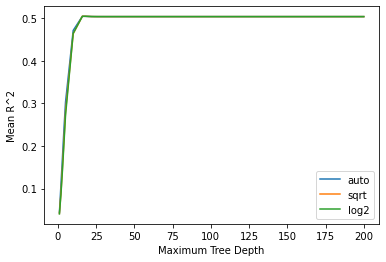

In [222]:
for param_max_feature in hyper_m_list:
    plt.plot('param_max_depth','mean_test_score',label = param_max_feature, data = cv_df[cv_df["param_max_features"]== param_max_feature])
    plt.xlabel("Maximum Tree Depth")
    plt.ylabel("Mean R^2")
    plt.legend()

In [223]:
def hyperparam_plot2d(df, param, outcome, group_var = None):

    '''
    func: function to plot the performance of a parameter
    - df (dataframe): cross-validation grid search dataframe

    params have to be column names in DF
    - param (str): which parameter to asses
    - outcome (str): which outcome to find the max for
    - group_var (str): grouping variable (default None)
    '''

    group_var_list = np.unique(np.array(df[group_var]))
    plt.figure(figsize=(12,8))
    #print(np.argmax(np.asarray(df[outcome])))
    best_score = np.max(np.asarray(df[outcome]))
    best_score_param = np.asarray(df[param])[np.argmax(np.asarray(df[outcome]))]
    if group_var != None:
        best_score_group = np.asarray(df[group_var])[np.argmax(np.asarray(df[outcome]))]
        #print(best_score_group)

    if group_var == None:
        plt.plot(param,outcome,data = df)
        plt.xlabel(param)
        plt.ylabel(outcome)
        #plt.grid()
        plt.vlines(best_score_param, 0, np.max(np.asarray(df[outcome])+.05))
        plt.text(best_score_param,best_score + .05,  f'Best parameter: {best_score_param} with score: {best_score}')
        plt.legend()
    else:
        for inst in group_var_list:
            plt.plot(param,outcome,label = inst, data = df[df[group_var]== inst])
            plt.xlabel(param)
            plt.ylabel(outcome)
            #plt.grid()
            plt.text(best_score_param,best_score + .05,  f'Best parameter: {best_score_param} \n with score: {round(best_score,3)} \nin group:{best_score_group}')
            plt.vlines(best_score_param, 0, best_score+.05)
            plt.legend(loc = 4)
            plt.ylim(bottom =0 )
    plt.grid()
    return plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

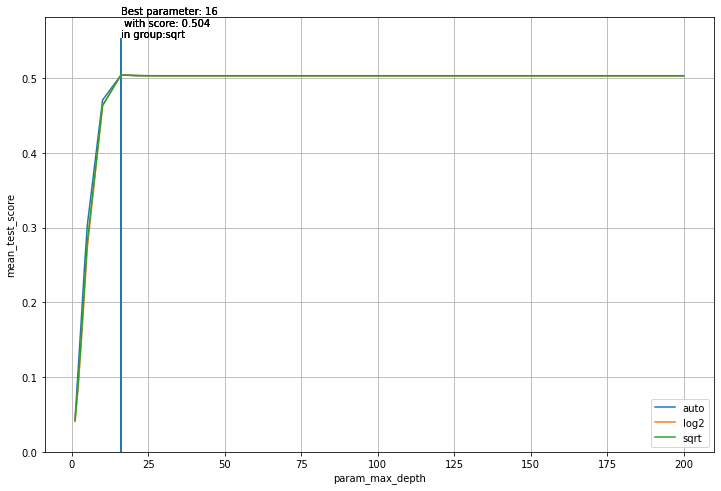

In [224]:
hyperparam_plot2d(cv_df, 'param_max_depth', 'mean_test_score', 'param_max_features')

<function matplotlib.pyplot.show(close=None, block=None)>

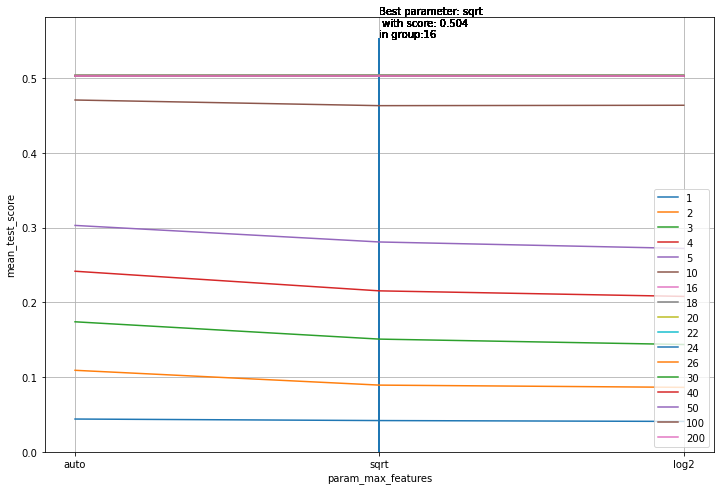

In [225]:
hyperparam_plot2d(cv_df, 'param_max_features' ,'mean_test_score','param_max_depth')

In [227]:
best_forest = grid_search.best_estimator_

# Evaluation on Test Set

In [256]:
# We have to apply the same pre-processing by PCA to the test set.
X_test_pca = pca.transform(X_test)
pd.DataFrame(X_test_pca, y_test).to_csv("train_set_pca.csv")

In [235]:
## Linear Regression
lin_model.score(X_test_pca, y_test)

## My interpretation: This model is completely useless because does not attribtue for the non-linearity of the data. 
# The test R^2 being better than train means essentially nothing because the models are so bad.

0.07023980708991395

In [231]:
## Best forest: 
best_forest.score(X_test_pca, y_test)

# This is quite good, given that the best train score of 0.504132 with an SD of like 0.06 so we are not significantly different to that. 

0.4913850434580447

In [240]:
best_forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 16,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}